In [1]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [2]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

In [3]:
# # OCTOBER 21 FLIGHT READ IN

# keys1021 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/*')]
# keys1021.sort()
# 
# dict1021 = {}
# for key in keys1021:
#     with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
#         loaded_dict = pickle.load(f)
#     dict1021[key] = dict_to_class_cut(loaded_dict)
#     print(key)


In [4]:
# # OCTOBER 22 FLIGHT READ IN

# keys1022 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/20211022T*')]
# keys1022.sort()

# dict1022 = {}
# for key in keys1022:
#     with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
#         loaded_dict = pickle.load(f)
#     dict1022[key] = dict_to_class_cut(loaded_dict)
#     print(key)

In [5]:
## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in keys826:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


20210826T162036Z
20210826T170324Z
20210826T182915Z
20210826T185632Z
20210826T192108Z
20210826T195014Z


# Task 1: 2D gaussian fits for main beam flight (ie plots below)!

Step 1: visual check\
Step 2, make following plots:
- Full-width-half-max in x,y as function of frequency 
- beam center in x,y as function of frequency 

Step 3: Repeat for side lobe flights

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


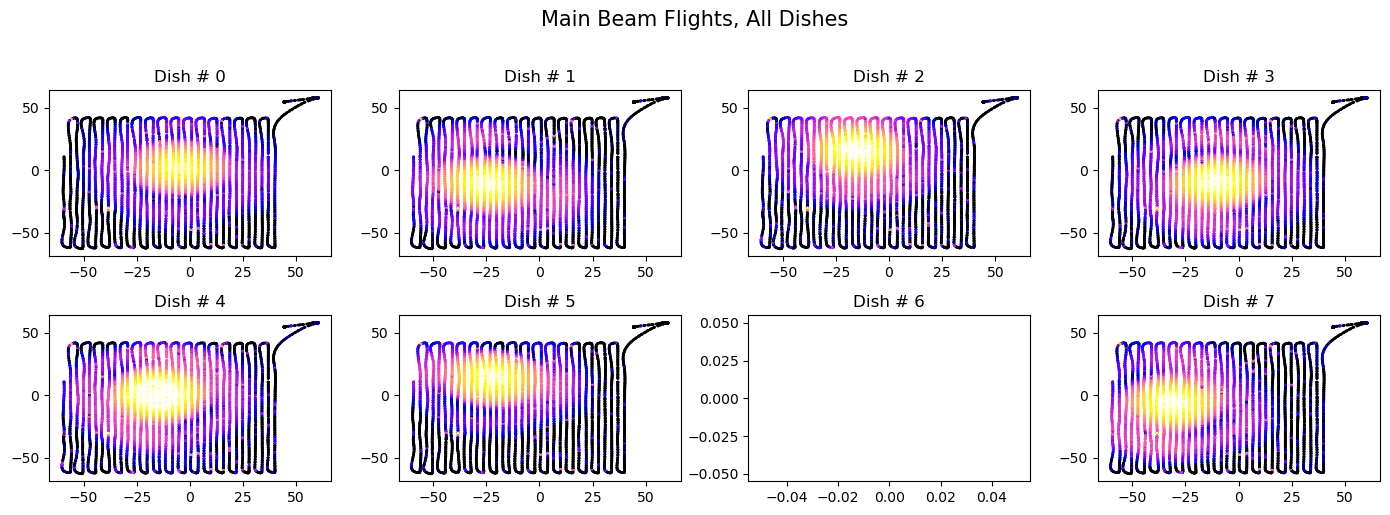

In [6]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

i = '20210826T195014Z'
for k in range(8):
    dotsize=1
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    
    ax=fig.add_subplot(2,4,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,2*k+1], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('Dish # '+str(k))
    counter +=1

suptitle('Main Beam Flights, All Dishes', y=1.02, fontsize = 15)
tight_layout()

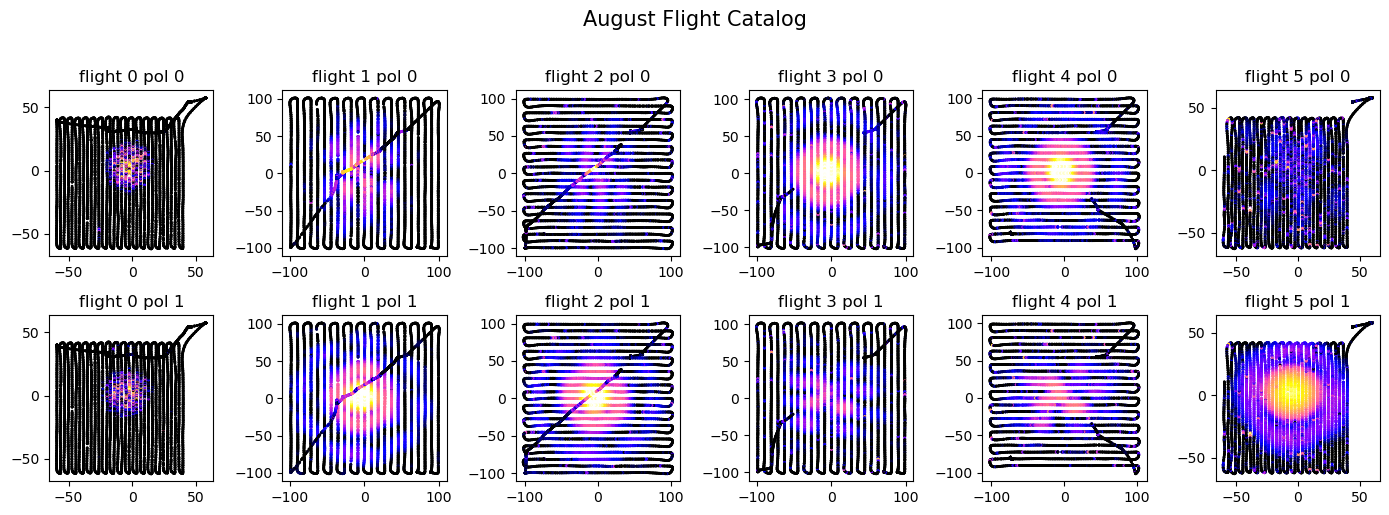

In [7]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    dotsize=1
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    
    ax=fig.add_subplot(2,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')

    ax=fig.add_subplot(2,6,counter+6)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('August Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

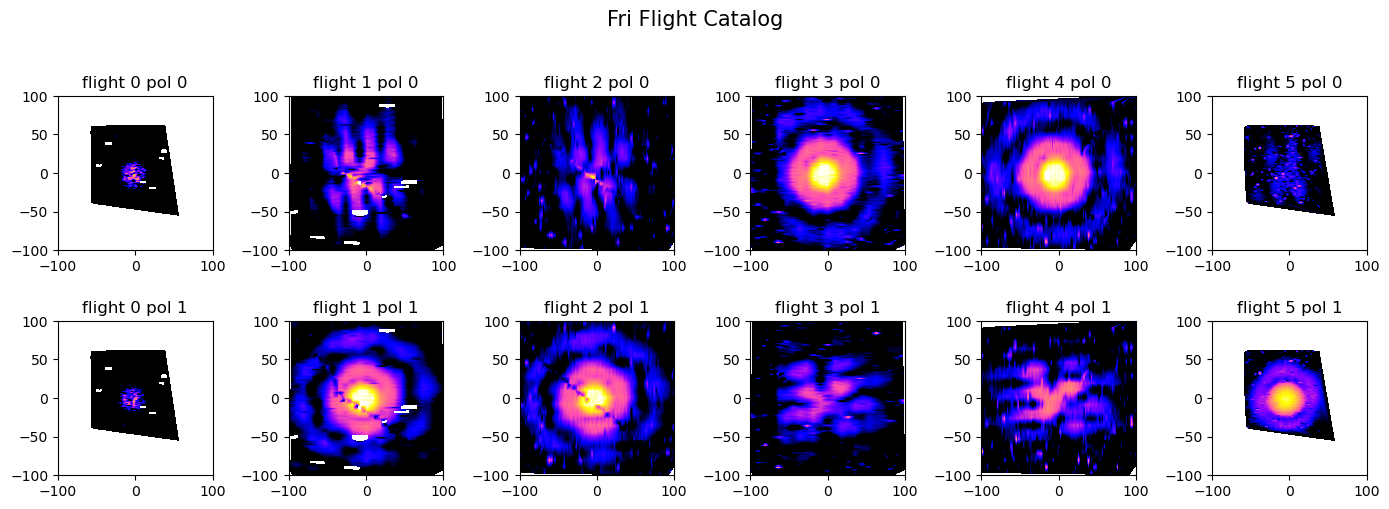

In [8]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    dotsize=2
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    X,Y = np.meshgrid(np.linspace(-100,100,2000), np.linspace(-100,100,2000))
    
    ax=fig.add_subplot(2,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-100,100,-100,100), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')

    ax=fig.add_subplot(2,6,counter+6)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-100,100,-100,100), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('Fri Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

In [9]:
def twoD_Gaussian(v, *params):
    [amplitude, xo, yo, sigma_x, sigma_y, theta, offset] = params
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((v[0]-xo)**2) + 2*b*(v[0]-xo)*(v[1]-yo) 
                            + c*((v[1]-yo)**2)))
    return g.ravel()

In [11]:
num = 5 # looking at flight number 5 from 8/26

freq = 900 #look at frequency index 900

#find indices where source is on
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist() 

#find indices where there are no nans in position
indsuse = [i for i in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[i,0]) != 'nan']

x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V[indsuse,freq:freq+10,1], axis = 1))) # linear power, units uncalibrated, averaged over 10 frequency bins

#fit 2D gaussian
initial_guess = (1e-5, -5, 2, 7, 7, 0, 1e-7)
popt5, pcov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)

print('fit params = ', popt5)

fit params =  [ 7.39178786e-08 -4.65567247e+00  2.18151055e+00  9.73743103e+00
  9.00544088e+00  8.38070965e-02  2.76682820e-09]


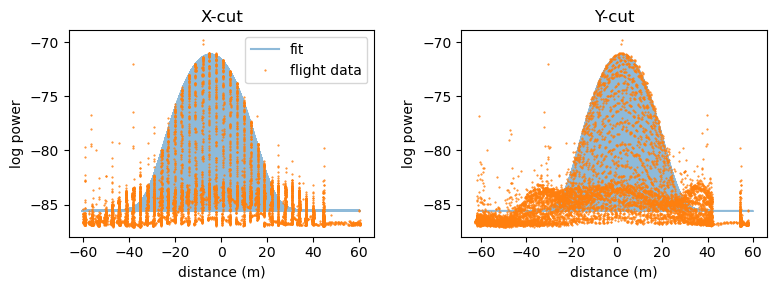

In [12]:
#check fitting by eye

x1 = np.linspace(-60,60,1000)
y1 = np.linspace(-60,60,1000)
X1,Y1 = np.meshgrid(x1,y1)
Z5 = 10*np.log10(twoD_Gaussian((X1,Y1),*popt5))


fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z5, alpha = 0.5, label = 'fit')
ax.plot(x,10*np.log10(z),'.', markersize = 1, label = 'flight data')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z5, alpha = 0.5)
ax.plot(y,10*np.log10(z),'.', markersize = 1)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()


fit params =  [ 1.58407605e-07 -2.13490967e+00 -4.78722538e-01  1.25833440e+01
  8.35254308e+00 -5.34581977e-01  2.37757545e-09]


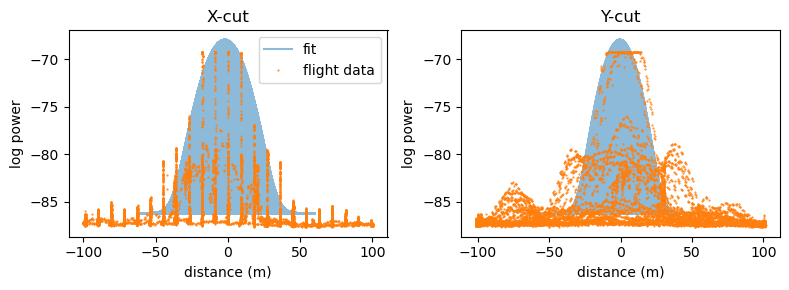

In [14]:
#will be harder to fit for gaussian in high powered flights, note flat tops

#check fitting by eye

num = 1 # looking at flight number 5 from 8/26

freq = 900 #look at frequency index 900
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist() 
indsuse = [i for i in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[i,0]) != 'nan']

x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V[indsuse,freq:freq+10,1], axis = 1))) # linear power, units uncalibrated, averaged over 10 frequency bins
initial_guess = (1e-5, -5, 2, 7, 7, 0, 1e-7)
popt1, pcov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)
print('fit params = ', popt1)

Z1 = 10*np.log10(twoD_Gaussian((X1,Y1),*popt1))

fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z1, alpha = 0.5, label = 'fit')
ax.plot(x,10*np.log10(z),'.', markersize = 1, label = 'flight data')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z1, alpha = 0.5)
ax.plot(y,10*np.log10(z),'.', markersize = 1)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()

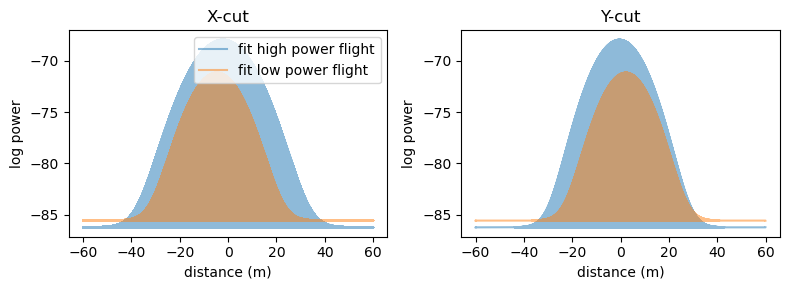

In [16]:


fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z1, alpha = 0.5, label = 'fit high power flight')
ax.plot(X1.ravel(),Z5, alpha = 0.5, label = 'fit low power flight')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z1, alpha = 0.5)
ax.plot(Y1.ravel(),Z5, alpha = 0.5)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()